### Document CLustering

In [111]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


with open('data.txt', 'r') as file:
    text = file.readlines()

all([length == 2 for length in [len(line.split('\t')) for line in text]])
labels, articles = [line.split('\t')[0].strip() for line in text], [line.split('\t')[1].strip() for line in text]
docs = pd.DataFrame(data=zip(labels, articles), columns=['label', 'article'])
docs.label = docs.label.astype('category')

# Use TF-IDF vectorizer to convert text data to features
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
features = tfidf_vectorizer.fit_transform(articles)

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features.toarray())

#### Implementing the hard-EM  and soft-EM on the above dataset. 
#### The number of clusters is set to K=4, and runing both the soft-EM and hard-EM algorithms on the data.

####  Performs a PCA on the clusterings based on the hard-EM and soft-EM 

In [112]:
class HardEMClustering:
    def __init__(self, K, max_iters=200):
        self.num_clusters = K #number of clusters
        self.max_iters = max_iters # Max number of EM iterations
        self.cluster_centers = None #will store the cluster centers
        self.cluster_assignments = None # will store the assignmnet of data points to clusters

    def initialize_clusters(self, data):
        # Randomly initialize cluster centers from the data points
        random_indices = np.random.choice(data.shape[0], self.num_clusters, replace=False)
        self.cluster_centers = data[random_indices]

     # E Step: Assign each data point to the closest cluster
    def expectation_step(self, data):
        #calculate the Euclidean distance betwween data points and cluster centers
        distances = np.linalg.norm(data[:, np.newaxis] - self.cluster_centers, axis=2) 
        self.cluster_assignments = np.argmin(distances, axis=1) #assigning datapoint to cluster with closest center

    # M Step: Update cluster centers based on the assigned data points
    def maximization_step(self, data):
        for cluster in range(self.num_clusters):
            #assigning data points to the current cluster
            cluster_data = data[self.cluster_assignments == cluster]
            if len(cluster_data) > 0:
                #update the cluster center to teh mean of assigned data points
                self.cluster_centers[cluster] = np.mean(cluster_data, axis=0)

    # main finction to train the model to perform EM steps
    def fit(self, data):
        data = np.array(data) #creating a numpy array for the dat points
        self.initialize_clusters(data) #randomly initialise data points

        for iteration in range(self.max_iters):
            print(f'Iteration: {iteration}')
            old_assignments = np.copy(self.cluster_assignments) #stores previous asssignments
            self.expectation_step(data)
            self.maximization_step(data)

            # Check for convergence by comparing the current assignments to the old assignmnets
            if np.array_equal(old_assignments, self.cluster_assignments):
                print(f'converging at: {iteration}')
                break

    def predict(self, data):
        # Assign data points to clusters based on the trained model
        distances = np.linalg.norm(data[:, np.newaxis] - self.cluster_centers, axis=2)
        cluster_assignments = np.argmin(distances, axis=1)
        return cluster_assignments



Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
converging at: 18


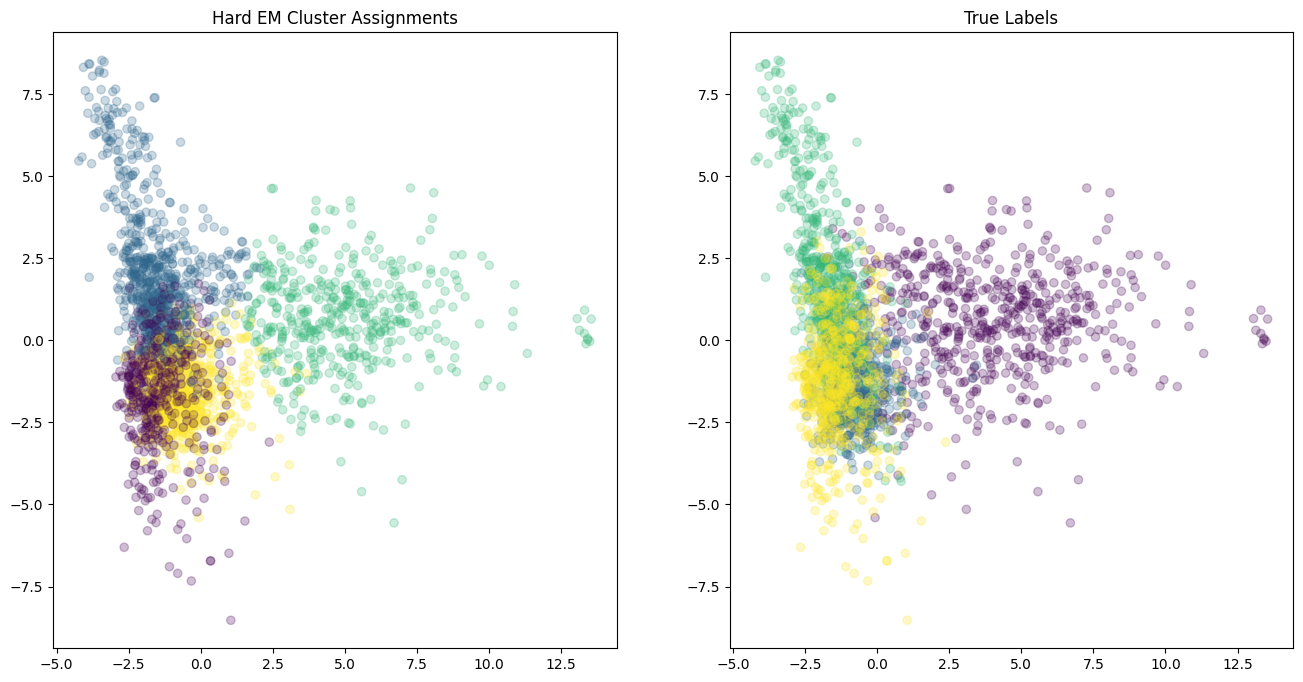

In [113]:
# Create and fit the HardEMClustering model
K = 4
hard_em = HardEMClustering(K)
hard_em.fit(features_scaled )
cluster_assignments_h = hard_em.predict(features_scaled)

# Perform PCA for visualization
pca = PCA(n_components=2)
_2D_features = pca.fit_transform(features_scaled)

# to plot the clustering
fig,axs=plt.subplots(1,2,figsize=(16,8))
axs[0].scatter(x=_2D_features[:, 0], y=_2D_features[:, 1], c=cluster_assignments_h, cmap='viridis', alpha=0.25)
axs[0].set_title('Hard EM Cluster Assignments')
axs[1].scatter(x=_2D_features[:, 0], y=_2D_features[:, 1], c=docs.label.cat.codes, cmap='viridis', alpha=0.25)
axs[1].set_title('True Labels')
plt.show()

In [130]:
class SoftEMClustering:
    def __init__(self, K, max_iters=100):
        self.num_clusters = K #number of clusters
        self.max_iters = max_iters # max number of iterations
        self.cluster_centers = None #will store the cluster centers
        self.cluster_probs = None # will store the cluster probabilities of data points 
       

    def initialize_clusters(self, data):
        # Randomly initialize cluster centers from the data points
        random_indices = np.random.choice(data.shape[0], self.num_clusters, replace=False)
        self.cluster_centers = data[random_indices]

    #E Step: Compute probabilities of data points belonging to each cluster
    def expectation_step(self, data):
        #calculate the Euclidean distance betwween data points and cluster centers
        distances = np.linalg.norm(data[:, np.newaxis] - self.cluster_centers, axis=2)
        #computes the cluster probabilities
        self.cluster_probs = np.exp(-distances) / np.sum(np.exp(-distances), axis=1)[:, np.newaxis]

    # M Step: Update cluster centers based on the weighted data points
    def maximization_step(self, data):
        for cluster in range(self.num_clusters):
            #updates each cluster center as the weighnted mean of the data points
            self.cluster_centers[cluster] = np.sum(self.cluster_probs[:, cluster, np.newaxis] * data, axis=0) / np.sum(self.cluster_probs[:, cluster])

    # main finction to train the model to perform EM steps
    def fit(self, data):
        data = np.array(data)
        self.initialize_clusters(data) #randomly initialise cluster centers

        for iteration in range(self.max_iters):
            print(f'iteration: {iteration}')
            old_centers = np.copy(self.cluster_centers) #store previous data of cluster centers
            self.expectation_step(data)
            self.maximization_step(data)

            # Check for convergence by comparing the current assignments to the old assignmnets
            if np.allclose(old_centers, self.cluster_centers, atol=1e-3):
                print(f"Converging at {iteration}")
                break

    def predict(self, data):
        # Compute cluster assignments based on the probabilities
        cluster_assignments = np.argmax(self.cluster_probs, axis=1)
        return cluster_assignments





iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
Converging at 6


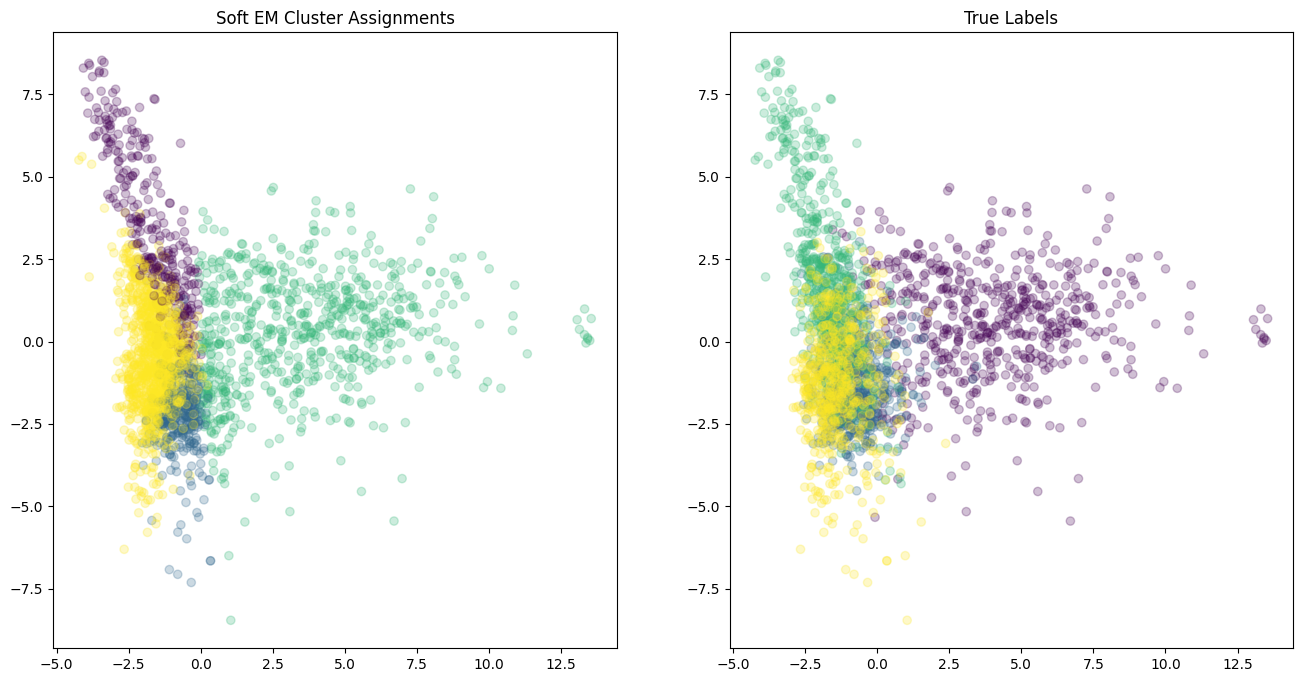

In [136]:
# Create and fit the SoftEMClustering model
K = 4
soft_em = SoftEMClustering(K)
soft_em.fit(features_scaled)
cluster_assignments_s = soft_em.predict(features_scaled)

# Perform PCA for visualization
pca = PCA(n_components=2)
_2D_features = pca.fit_transform(features_scaled)

# to visualise the plot
fig,axs=plt.subplots(1,2,figsize=(16,8))
axs[0].scatter(x=_2D_features[:, 0], y=_2D_features[:, 1], c=cluster_assignments_s, cmap='viridis', alpha=0.25)
axs[0].set_title('Soft EM Cluster Assignments')
axs[1].scatter(x=_2D_features[:, 0], y=_2D_features[:, 1], c=docs.label.cat.codes, cmap='viridis', alpha=0.25)
axs[1].set_title('True Labels')

plt.show()

#### Hard-EM and Soft-EM analysis based on the plot

The key difference between the Soft EM and Hard EM is in how they handle the assignment of data points to clusters, as well as how they update cluster centers during the E-step and M-step of the EM algorithm. 

1. **Hard EM**:
   - The `HardEMClustering` class hard-assigns each data point to a single cluster during the E-step. It finds the cluster with the closest center and assigns the data point to that cluster.
   - In the M-step, the cluster centers are updated based on the mean of the data points assigned to each cluster.
   

2. **Soft EM Code**:
   - The `SoftEMClustering` class computes probabilities of data points belonging to each cluster during the E-step. These probabilities are soft assignments, meaning each data point is associated with each cluster with some probability.
   - In the M-step, the cluster centers are updated based on a weighted combination of all data points, where the weights are the probabilities from the E-step.
   - Soft EM allows for a more probabilistic interpretation of cluster assignments, where data points can belong to multiple clusters with varying probabilities.

**Based on the plot, we can notice that soft EM does a better job at clustering the data and has lesser overlap when compared to hard EMplot. We can conclude that soft EM is more flexible and better than Hard EM.**

In summary, the Soft EM code assigns data points to clusters with probabilities (soft assignment), allowing for more flexibility in modeling data with mixed memberships. Soft EM is often used when the assumption of hard assignments is too restrictive for the data.